In this notebook, we run some sanity checks on the out-of-the-box GCN.

### imports and setup

In [1]:
# # google colab setup (comment out this cell if running locally)
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd "/content/drive/My Drive/_research ML AQ/lorenz 96 gnn" # so we can access pre-generated lorenz data
# !pip3 install spektral

In [15]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# import packages
import numpy as np
import tensorflow as tf

2023-02-09 11:28:48.736878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import matplotlib.pyplot as plt


In [5]:

from lorenz import lorenzDataset, DEFAULT_TIME_RESOLUTION
from plotters import plot_data
from tuning import make_train_GCN, plot_model_results
from models import NaiveConstant, NaiveZero

from spektral.data import MixedLoader

from datetime import datetime

from sanity_check_helpers import *

In [6]:
# check that GPU is set up
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('no GPU device found')
else:
  print('found GPU at: {}'.format(device_name))
print('num GPUs available:', len(tf.config.list_physical_devices("GPU")))

no GPU device found
num GPUs available: 0


2023-02-09 11:28:57.296575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### prepare data

In [7]:
# only uncomment each line if testing a non-default parameter
dataset100 = lorenzDataset(
    n_samples=100,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    # K=36,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42
)

reading Lorenz data from stored file


In [8]:
# only uncomment each line if testing a non-default parameter
dataset = lorenzDataset(
    n_samples=10_000,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    # K=36,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42
)

reading Lorenz data from stored file


In [9]:
train = dataset[:int(0.8 * dataset.n_graphs)]
val = dataset[int(0.8 * dataset.n_graphs):]

train100 = dataset100[:int(0.8 * dataset100.n_graphs)]
val100 = dataset100[int(0.8 * dataset100.n_graphs):]

In [10]:
train_loader = MixedLoader(dataset=train, batch_size=32, shuffle=False)
val_loader = MixedLoader(dataset=val, batch_size=32, shuffle=False)
train100_loader = MixedLoader(dataset=train100, batch_size=32, shuffle=False)
val100_loader = MixedLoader(dataset=val100, batch_size=32, shuffle=False)

In [11]:
# TODO: store normalized train/val/test data

# normalize data
start = datetime.now()
X1_mean, X1_std, X2_mean, X2_std = train.get_mean_std()
X1_mean100, X1_std100, X2_mean100, X2_std100 = train100.get_mean_std()
finish_get_means = datetime.now()
print('time to get means:', finish_get_means - start)

train.normalize(X1_mean, X1_std, X2_mean, X2_std)
val.normalize(X1_mean, X1_std, X2_mean, X2_std)
train100.normalize(X1_mean100, X1_std100, X2_mean100, X2_std100)
val100.normalize(X1_mean100, X1_std100, X2_mean100, X2_std100)
finish_normalize = datetime.now()

print('time to normalize data:', finish_normalize - finish_get_means)

time to concat: 0:00:00.959154
time to get std&mean from X1: 0:00:01.522887
time to get std&mean from X2: 0:00:00.514355
time to concat: 0:00:00.011591
time to get std&mean from X1: 0:00:00.007504
time to get std&mean from X2: 0:00:00.002775
time to get means: 0:00:03.110735
time to normalize data: 0:00:01.496907


inspect data
(commented out because it takes too long to plot so many data points and I'm confident I know what it looks like)

In [12]:
# fig, (ax0, ax1) = plot_data(train, val, test, node=0)

# plt.tight_layout()
# plt.show()

## sanity checks

#### sanity check: initial error is reasonable

TODO: calculate expected initial error

#### sanity check: increasing regularization causes increasing loss

regularization reduces the amount of overfitting, thus increasing the loss on the training set

Epoch 1/10
250/250 [==============================] - 2s 3ms/step - loss: 4.4788
Epoch 2/10
250/250 [==============================] - 1s 3ms/step - loss: 2.0416
Epoch 3/10
250/250 [==============================] - 1s 3ms/step - loss: 2.2233
Epoch 4/10
250/250 [==============================] - 1s 4ms/step - loss: 2.7749
Epoch 5/10
250/250 [==============================] - 1s 3ms/step - loss: 2.3868
Epoch 6/10
250/250 [==============================] - 1s 3ms/step - loss: 1.7243
Epoch 7/10
250/250 [==============================] - 1s 3ms/step - loss: 1.5293
Epoch 8/10
250/250 [==============================] - 1s 3ms/step - loss: 1.2958
Epoch 9/10
250/250 [==============================] - 1s 3ms/step - loss: 1.2170
Epoch 10/10
250/250 [==============================] - 1s 3ms/step - loss: 1.0758
Epoch 1/10
250/250 [==============================] - 2s 5ms/step - loss: 16.5181
Epoch 2/10
250/250 [==============================] - 1s 5ms/step - loss: 6.0921
Epoch 3/10
250/250 [======

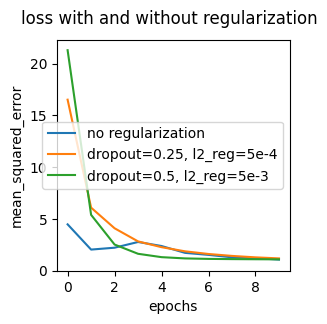

In [13]:
check_regularization(train, val)

This looks good - as we increase regularization (and dropout), the loss increases (initially), but they appear to converge with more training. 

### overfitting
make sure the GCN is capable of overfitting, i.e. the model has enough flexibility. using a tiny number of samples (e.g. 20) and setting regularization to 0, we want to make sure we can actually get to 0 error. 

(we also set dropout to 0 since dropout is supposed to help avoid overfitting.)

1/1 [==============================] - 0s 31ms/step


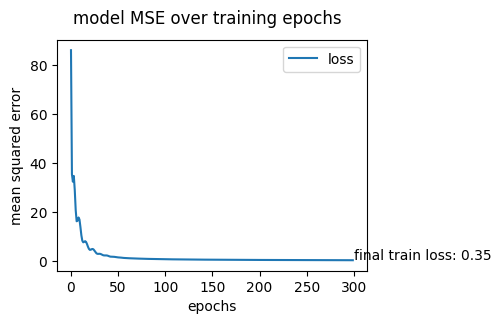

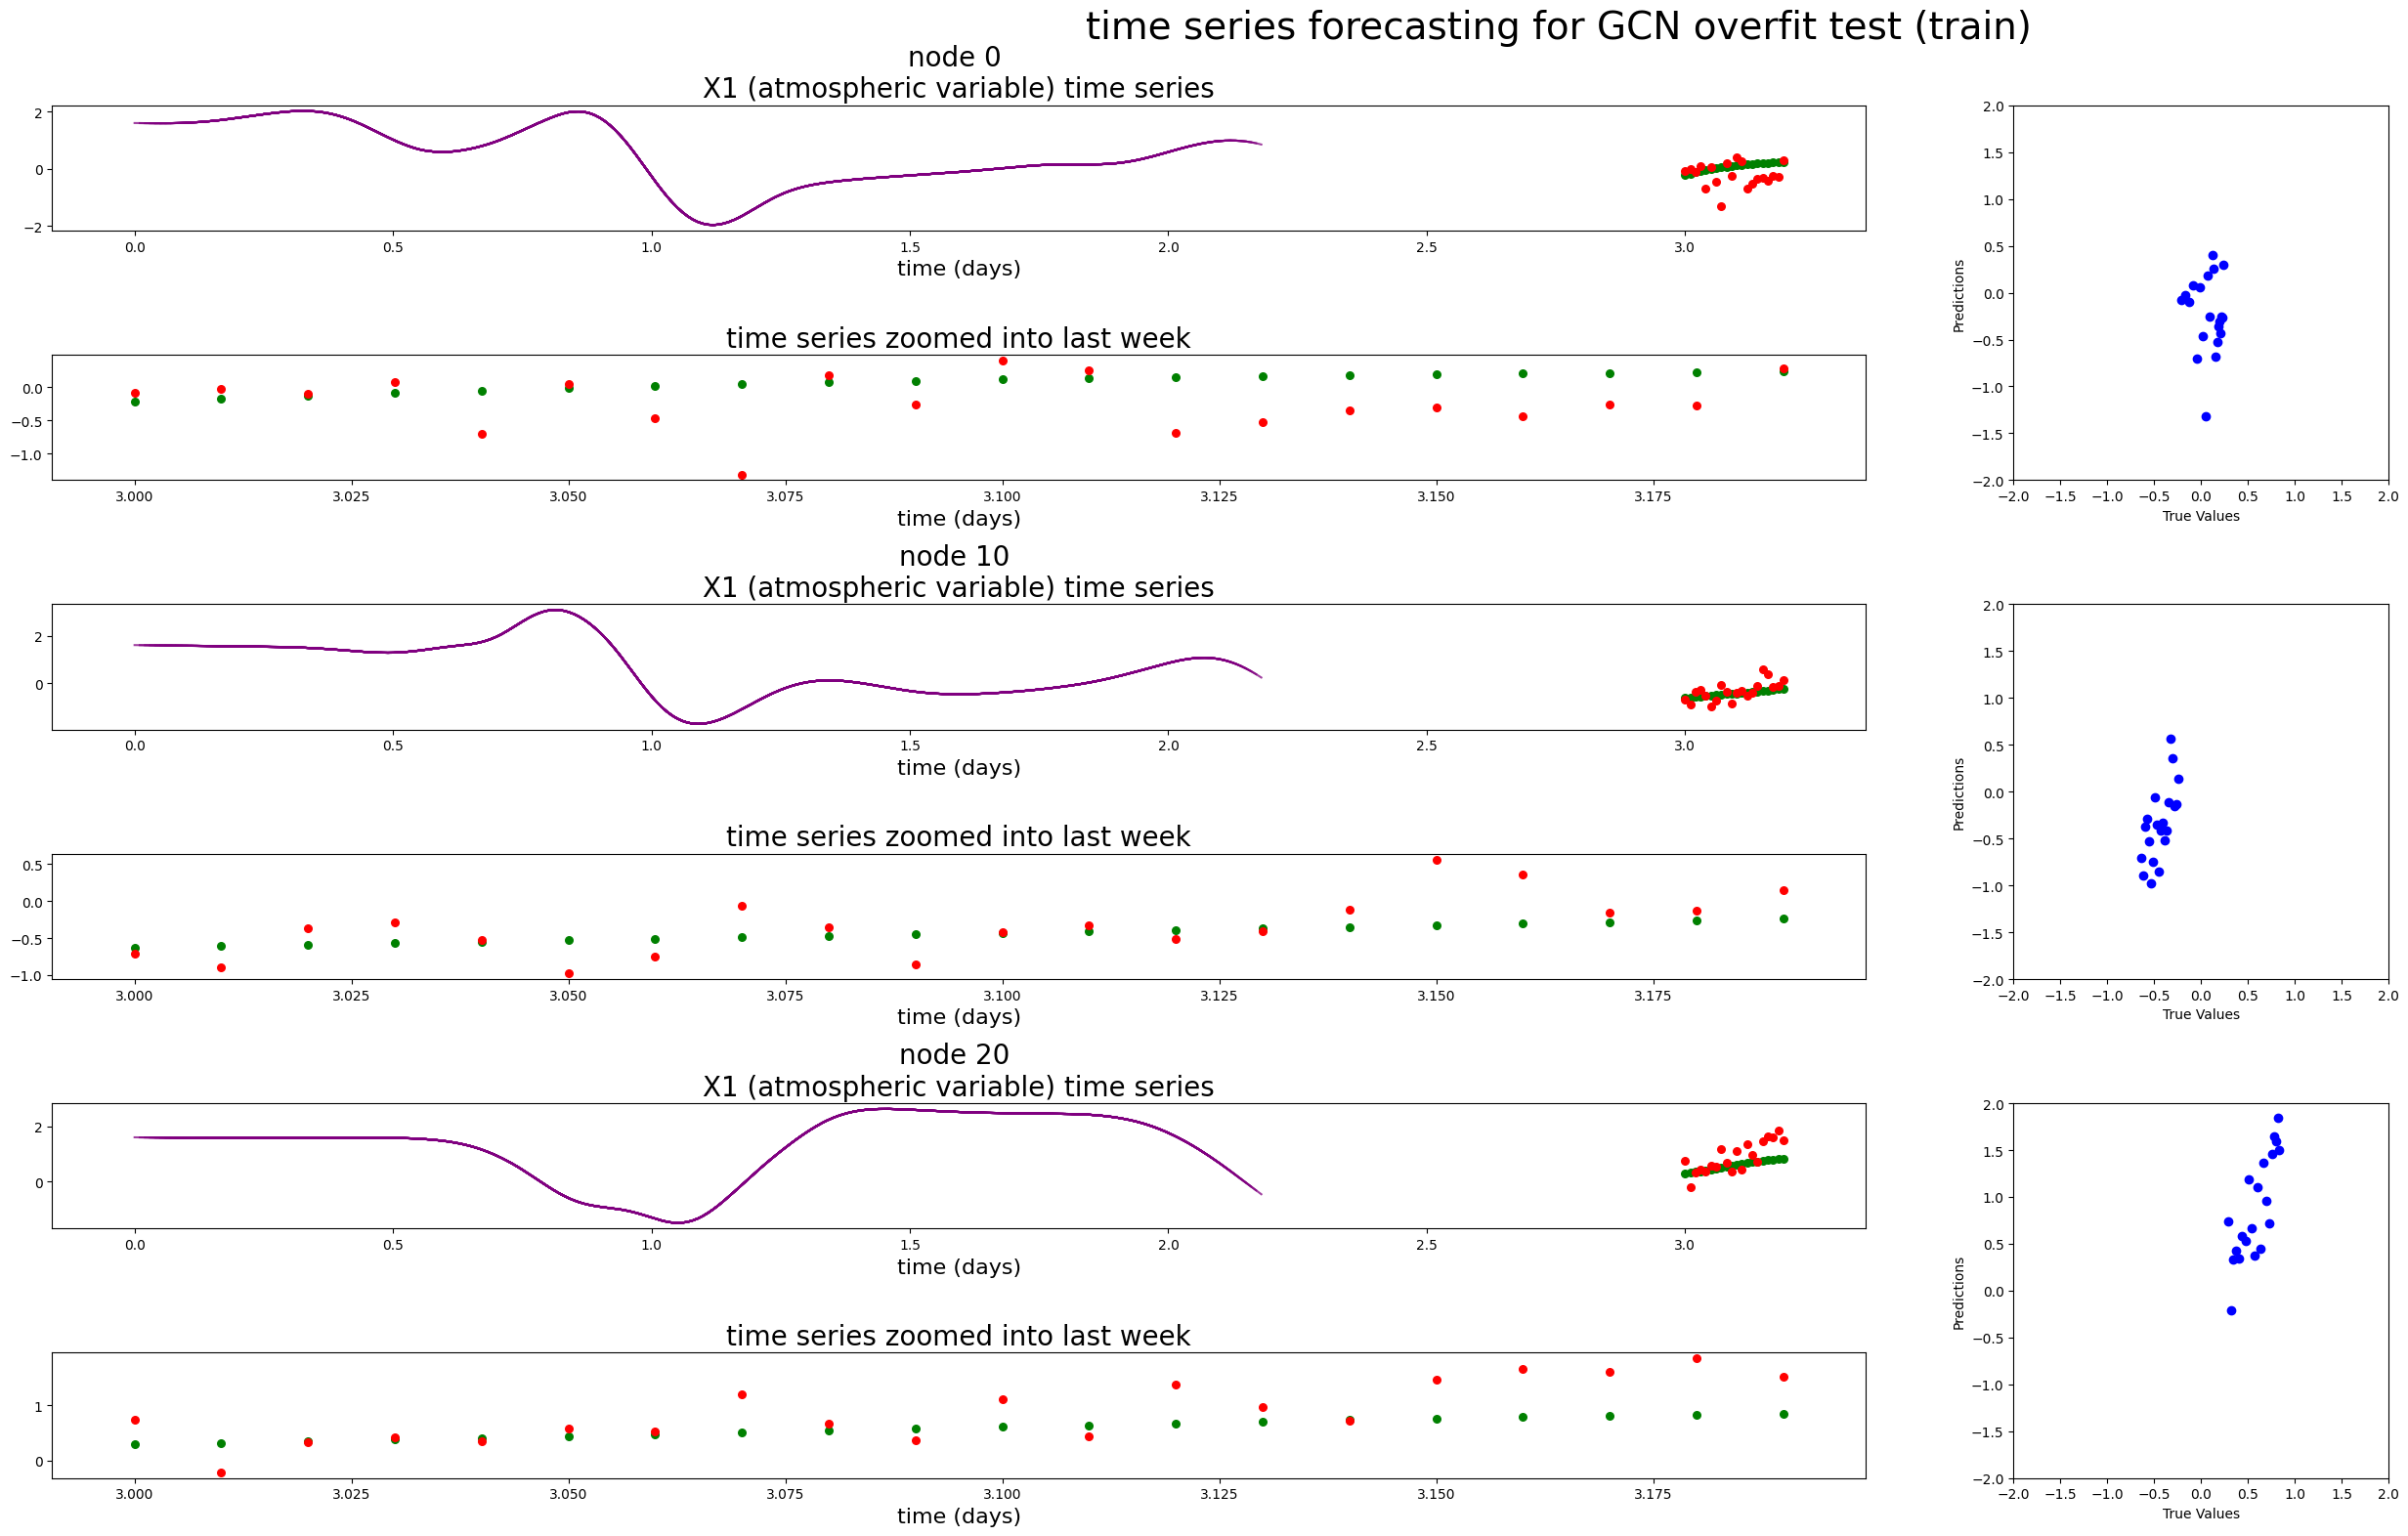

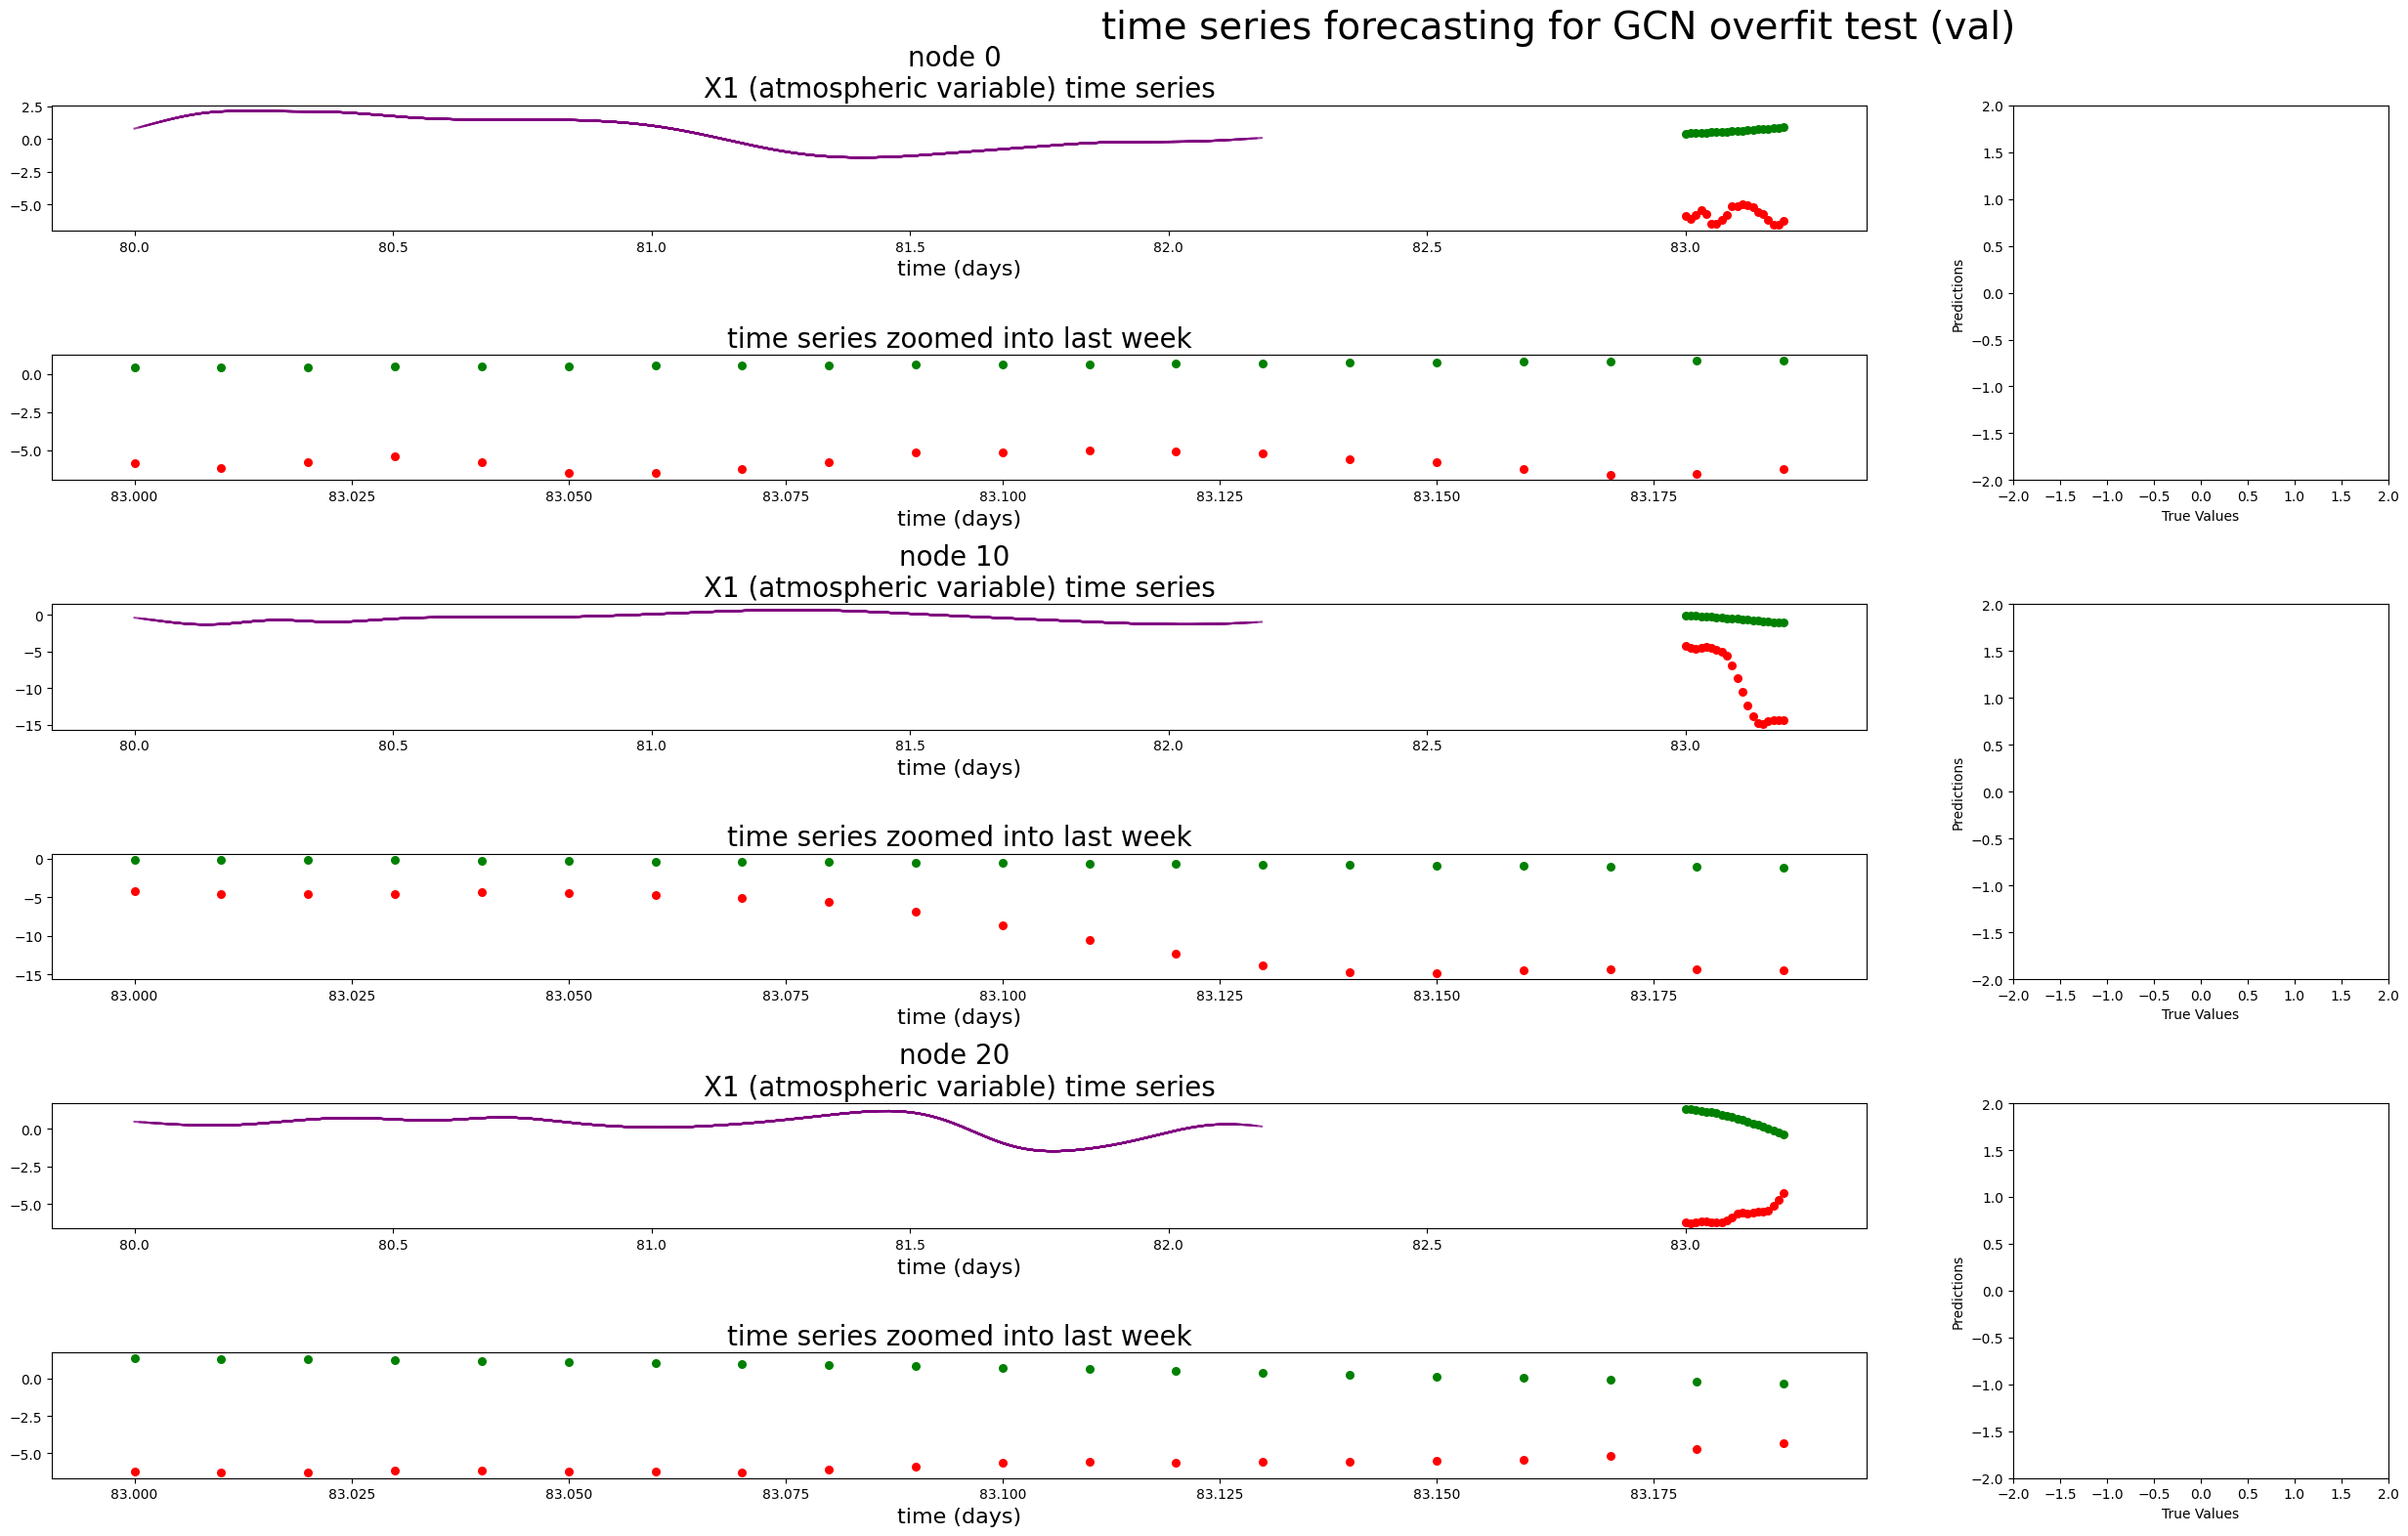

In [16]:
fig_train_loss, fig_train_pred, fig_val_pred = check_overfit(train[:20], val[:20], epochs=300, verbose=0, tensorboard=True)

In [17]:
%tensorboard --logdir logs/fit


Try increasing the number of data points to xxx since running it with just 20 data points yielded ridiculously high initial MSE. 

1/1 [==============================] - 0s 31ms/step


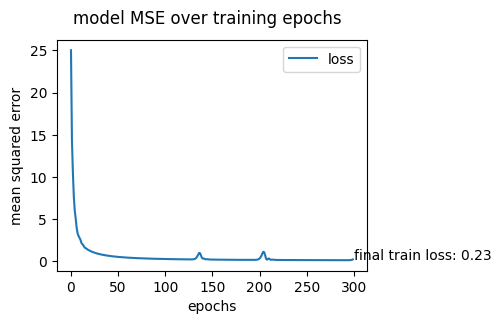

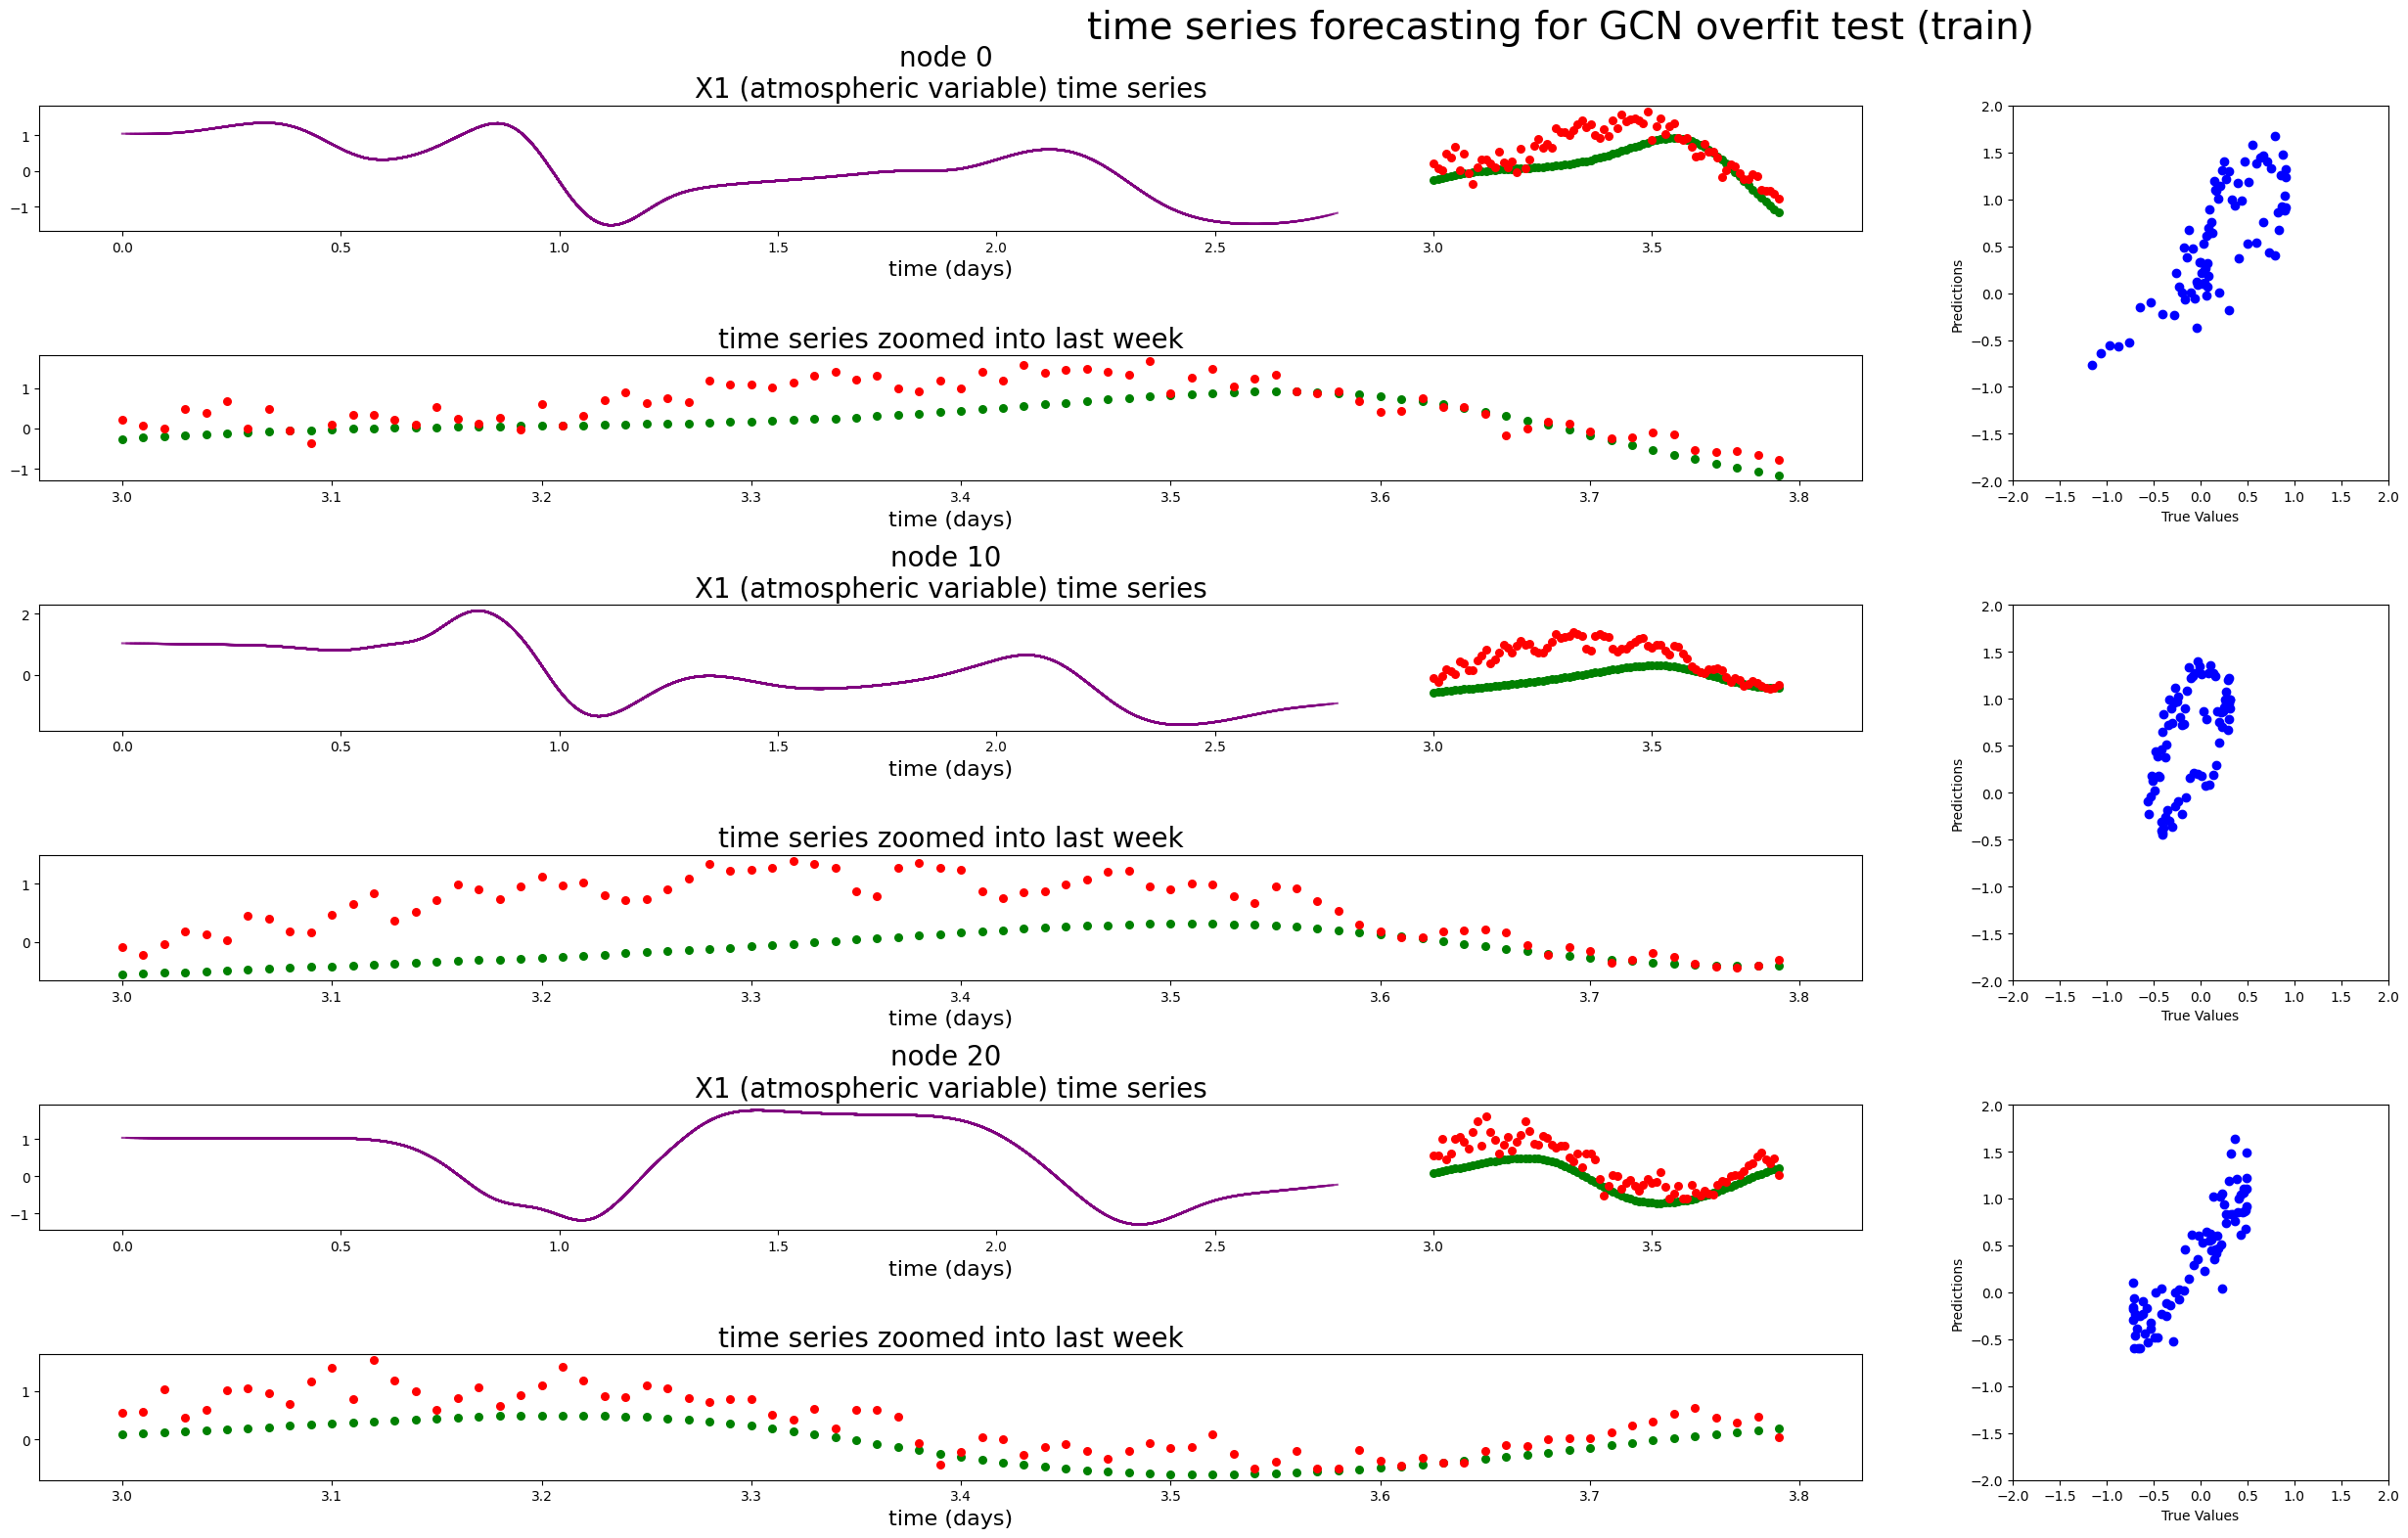

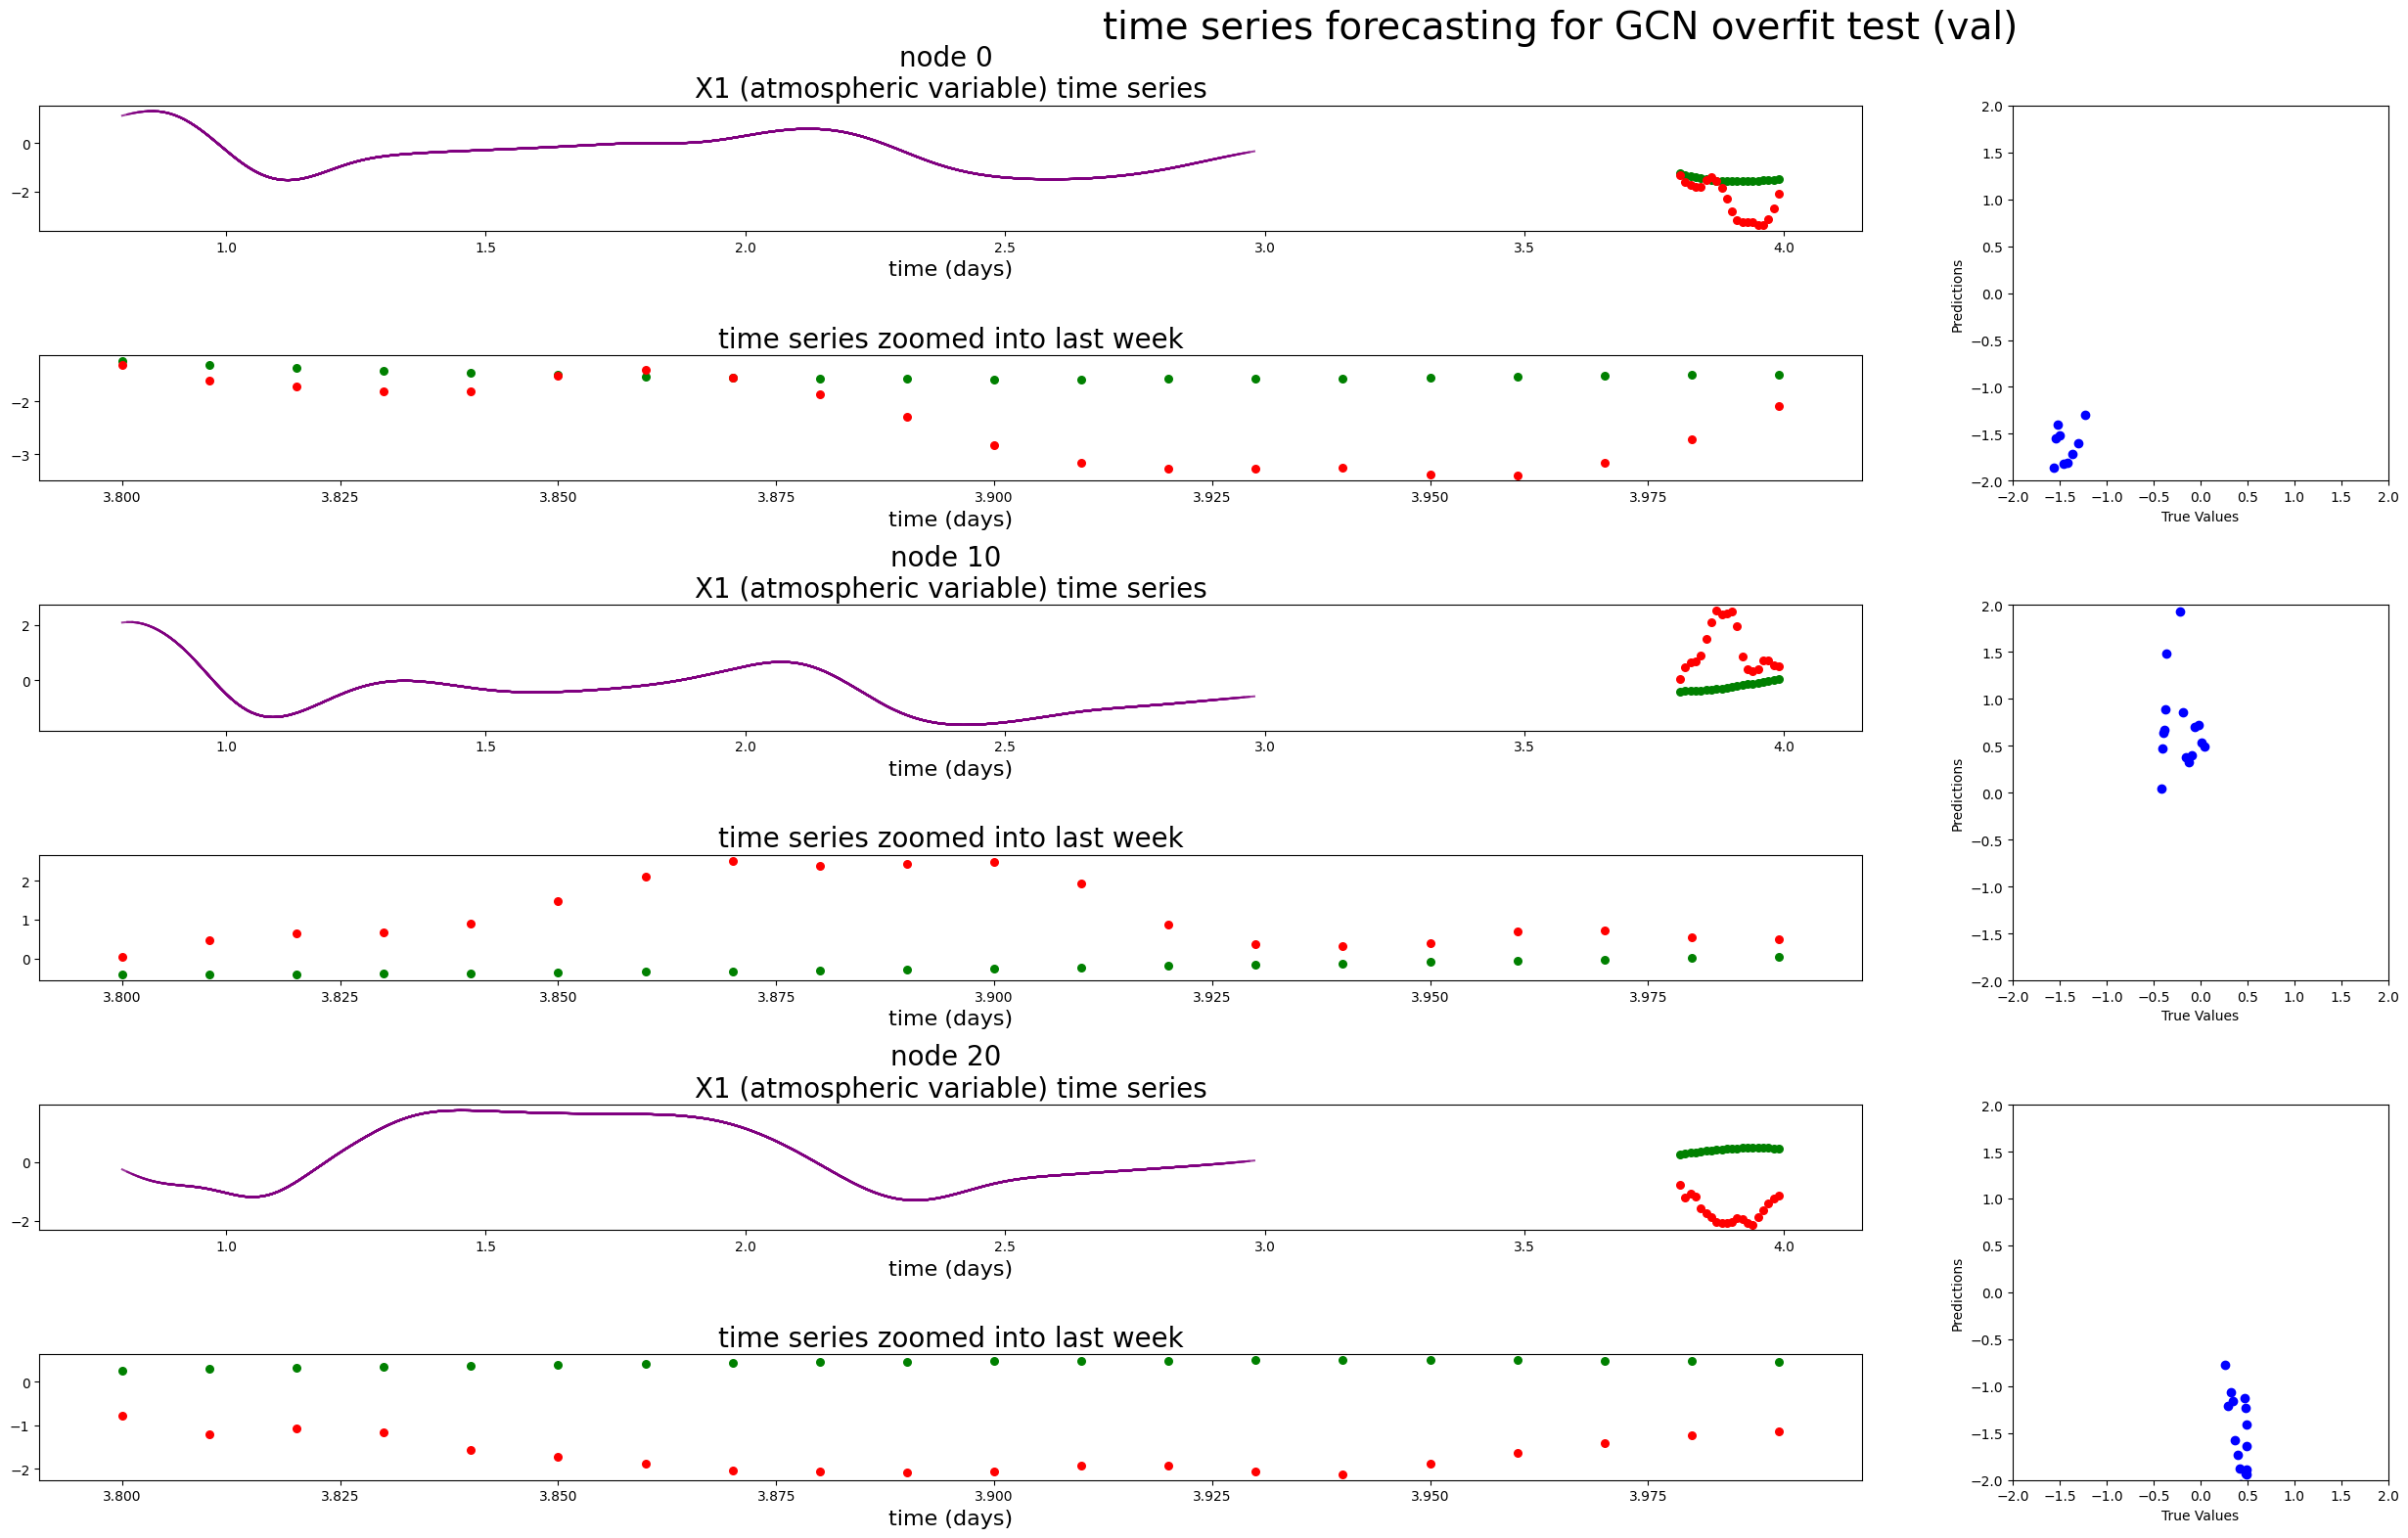

In [18]:
fig_train_loss, fig_train_pred, fig_val_pred = check_overfit(train100, val100, epochs=300, verbose=0, tensorboard=True)

In [19]:
fig_train_loss, fig_train_pred, fig_val_pred = check_overfit(train[:1000], val[:1000], epochs=300, verbose=0, tensorboard=True)

32/32 [==============================] - 0s 4ms/step


KeyboardInterrupt: 

Ok, I think we've satisfactorally shown that we can overfit on a small amount of data. Also, notice how the true/pred plot in blue reveals a very very slight positive linear trend... (at least for the training data)

Those are some interesting peaks around epochs 90, 140, 180, etc... I wonder what that's indicative of? 